In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.plotting import plot_trajectories, plot_height, plot_crash_site, plot_theoretical_empirical_observation_error
import numpy as np
from deorbit.observer import Observer

In [2]:
save_path = "eg/report_sim/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


In [3]:
obs = Observer(number_of_radars=10)
sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)

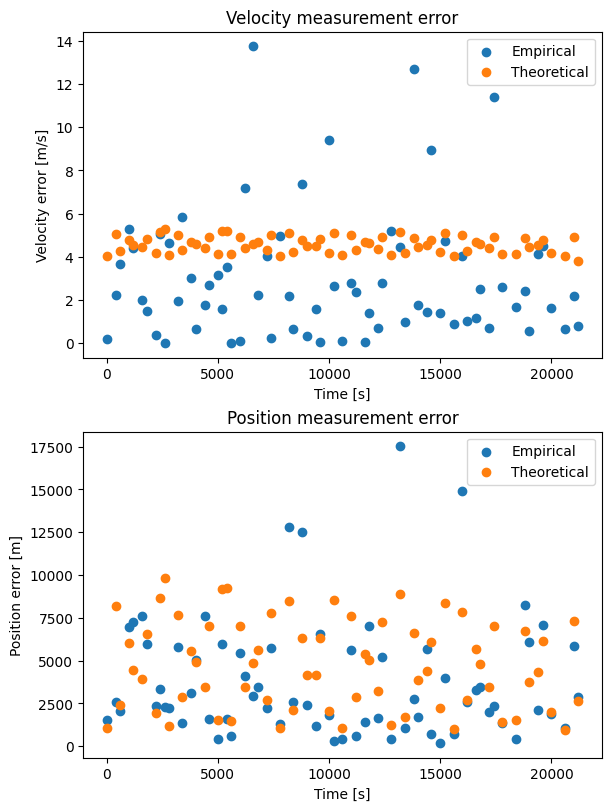

In [4]:
plot_theoretical_empirical_observation_error(sim_states, sim_times, observation_states, observation_times, observed_covariances)

In [5]:
# Define process and measurement noise covariance matrices
Q = np.diag([0.1, 0.1, 0.01, 0.01])#process noise
P = np.eye(4) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly)
H = np.eye(4)

dt = sim_config.simulation_method_kwargs.time_step

ekf = EKF()

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=observed_covariances, P=P, H=H)

100%|██████████| 69/69 [00:03<00:00, 22.79it/s]
